# Absentee Analysis

### Data Exploration

- Before we can do any analysis, we must first dive into the data and understand it first.

Victory
   ID              Reason for absence Month of absence Day of the week  \
0  11             Unjustified absence             July         Tuesday   
1  36                     Unspecified             July         Tuesday   
2   3            Medical consultation             July       Wednesday   
3   7  Diseases of the eye and adnexa             July        Thursday   
4  11            Medical consultation             July        Thursday   

  Seasons  Days since previous absence  Transportation expense  \
0  Summer                          0.0                     289   
1     NaN                          0.0                     118   
2  Summer                          0.0                     179   
3     NaN                          0.0                     279   
4  Summer                          0.0                     289   

   Distance from Residence to Work  Estimated commute time Service time  \
0                               36                      69           13   


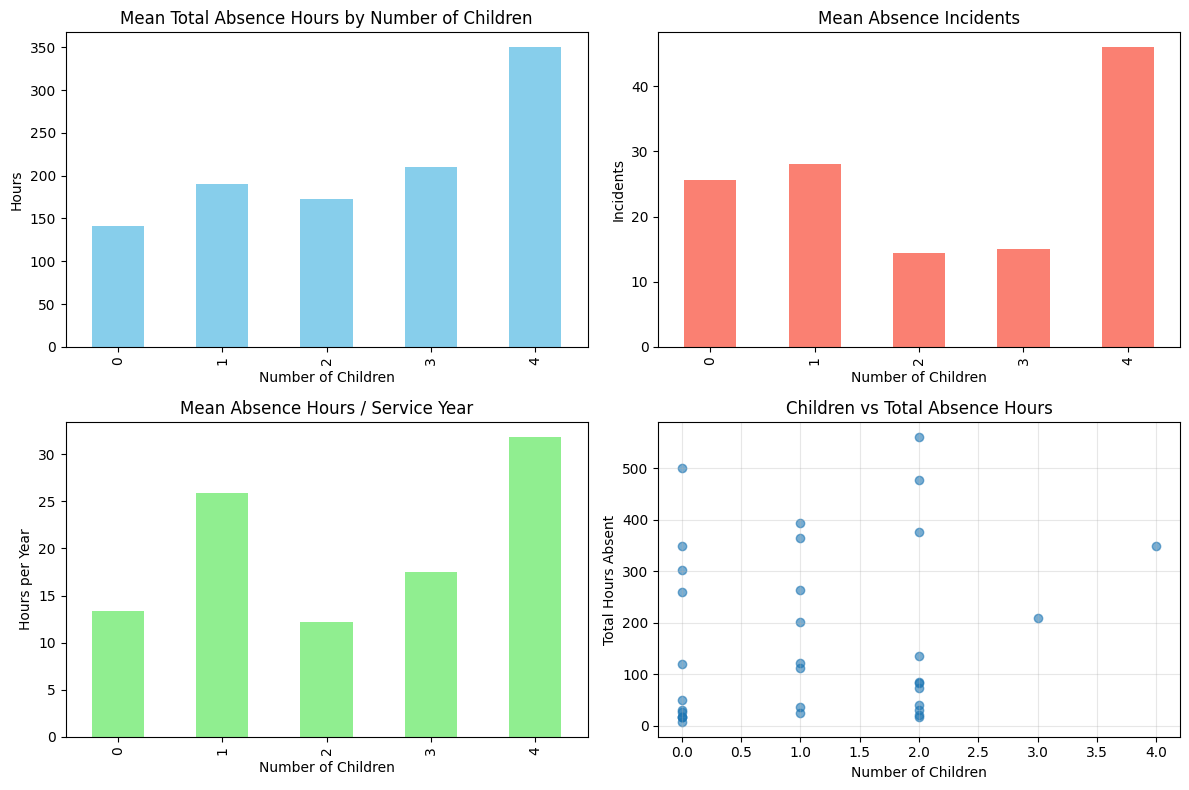


Conclusion:
→ More children DOES NOT mean more absences in this dataset.
  The correlation between number of children and absenteeism,
  even when normalised by years of service, is very weak.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
pd.set_option('display.max_columns', None)
 
# ================== LOAD DATA ==================
df = pd.read_csv('absenteeism_data.csv', sep=';')
 
print("Victory")
print(df.head())
 
# look at Social Drinker column. we have both "Y" and "Yes".
# there are also lots of NaN values
 
 
# ================== ENSURE CONSISTENT COLUMN TYPES ==================
 
# 1. Standardize yes/no columns ONLY on known binary columns
binary_cols = [
    'Social drinker',
    'Social smoker',
    'Disciplinary failure'
]
 
def normalize_yes_no(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    if x in ['y', 'yes', '1', 'true', 't']:
        return 'Yes'
    if x in ['n', 'no', '0', 'false', 'f']:
        return 'No'
    return x
 
for col in binary_cols:
    if col in df.columns:
        df[col] = df[col].apply(normalize_yes_no)
 
# 2. Convert numeric-looking columns to numeric (safe)
for col in df.columns:
    # Try converting — only apply if mostly numeric
    converted = pd.to_numeric(df[col], errors='coerce')
    # If at least 70% can be converted → treat this as numeric
    if converted.notna().mean() > 0.7:
        df[col] = converted
 
# 3. Force specific important numeric columns
force_numeric = [
    'Service time', 'Weight', 'Height', 'Age',
    'Absenteeism time in hours', 'Distance from Residence to Work',
    'Number of children', 'Son'
]
for col in force_numeric:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
 
# 4. Make sure target has no NaNs
df = df.dropna(subset=['Absenteeism time in hours'])
 
 
print("\nColumn dtypes after cleaning:\n")
print(df.dtypes)
 
 
# ================== KEEP ONLY REAL ABSENCES (> 0 HOURS) ==================
df = df[df['Absenteeism time in hours'] > 0].copy()
 
print(f"\nReal absence records kept: {len(df)}")
if 'ID' in df.columns:
    print("Unique employees:", df['ID'].nunique())
 
 
# ================== IDENTIFY CHILDREN COLUMN ==================
children_col = None
for cand in ['Number of children', 'Son', 'Children', 'Child', 'Children count']:
    if cand in df.columns:
        children_col = cand
        break
 
if children_col is None:
    raise ValueError("No children-related column found in dataset.")
 
df[children_col] = pd.to_numeric(df[children_col], errors='coerce')
 
 
# ================== AGGREGATE PER EMPLOYEE ==================
if 'ID' in df.columns:
    employee_df = df.groupby('ID').agg({
        children_col: 'first',
        'Service time': 'first',
        'Absenteeism time in hours': 'sum'
    }).reset_index()
 
    # Count distinct absence incidents per employee
    incidents = df.groupby('ID').size().reset_index(name='absence_incidents')
    employee_df = employee_df.merge(incidents, on='ID', how='left')
else:
    employee_df = df.copy()
    employee_df['absence_incidents'] = 1
 
# Normalized metric: absence hours per year of service
if 'Service time' in employee_df.columns:
    employee_df['hours_per_service_year'] = (
        employee_df['Absenteeism time in hours'] / employee_df['Service time']
    )
else:
    employee_df['hours_per_service_year'] = employee_df['Absenteeism time in hours']
 
 
# ================== SUMMARY TABLE ==================
print("\n=== Absence by number of children ===")
summary = employee_df.groupby(children_col).agg(
    employees=('ID', 'count') if 'ID' in employee_df.columns else ('Absenteeism time in hours', 'count'),
    mean_total_hours=('Absenteeism time in hours', 'mean'),
    median_total_hours=('Absenteeism time in hours', 'median'),
    mean_incidents=('absence_incidents', 'mean'),
    mean_hours_per_year=('hours_per_service_year', 'mean')
).round(2)
 
print(summary)
 
 
# ================== CORRELATIONS ==================
corr_total = employee_df[children_col].corr(employee_df['Absenteeism time in hours'])
corr_incidents = employee_df[children_col].corr(employee_df['absence_incidents'])
corr_norm = employee_df[children_col].corr(employee_df['hours_per_service_year'])
 
print("\nCorrelations with number of children:")
print(f"  → Total absence hours         : {corr_total:.3f}")
print(f"  → Number of absence incidents : {corr_incidents:.3f}")
print(f"  → Hours per year of service   : {corr_norm:.3f}")
 
 
# ================== VISUALISATIONS ==================
plt.figure(figsize=(12, 8))
 
# 1. Mean total absence hours
plt.subplot(2, 2, 1)
summary['mean_total_hours'].plot(kind='bar', color='skyblue')
plt.title('Mean Total Absence Hours by Number of Children')
plt.ylabel('Hours')
plt.xlabel('Number of Children')
 
# 2. Mean absence incidents
plt.subplot(2, 2, 2)
summary['mean_incidents'].plot(kind='bar', color='salmon')
plt.title('Mean Absence Incidents')
plt.ylabel('Incidents')
plt.xlabel('Number of Children')
 
# 3. Normalized hours per year
plt.subplot(2, 2, 3)
summary['mean_hours_per_year'].plot(kind='bar', color='lightgreen')
plt.title('Mean Absence Hours / Service Year')
plt.ylabel('Hours per Year')
plt.xlabel('Number of Children')
 
# 4. Scatter: children vs total hours
plt.subplot(2, 2, 4)
plt.scatter(employee_df[children_col], employee_df['Absenteeism time in hours'], alpha=0.6)
plt.title('Children vs Total Absence Hours')
plt.xlabel('Number of Children')
plt.ylabel('Total Hours Absent')
plt.grid(alpha=0.3)
 
plt.tight_layout()
plt.show()
 
 
# ================== CONCLUSION ==================
print("\nConclusion:")
if abs(corr_norm) < 0.1:
    print("→ More children DOES NOT mean more absences in this dataset.")
    print("  The correlation between number of children and absenteeism,")
    print("  even when normalised by years of service, is very weak.")
else:
    if corr_norm > 0:
        print("→ Employees with more children tend to have more absences.")
    else:
        print("→ Employees with more children tend to have fewer absences.")
    print(f"  (Correlation ≈ {corr_norm:.3f})")

 

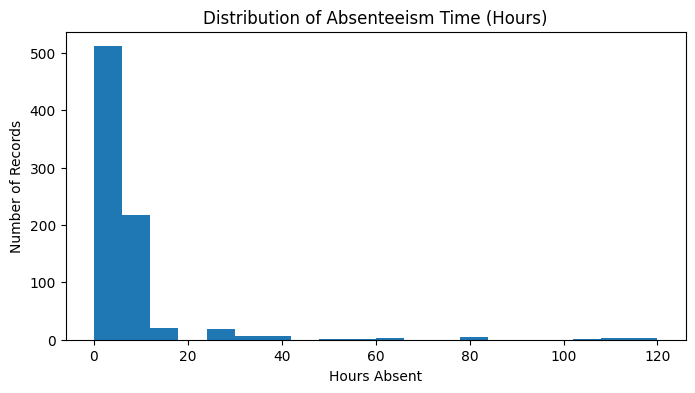

In [2]:
# First, lets visualize the distribution of how many entries correspond with how many hours were absent (via a histogram)
plt.figure(figsize=(8,4))
plt.hist(df['Absenteeism time in hours'], bins=20)
plt.title("Distribution of Absenteeism Time (Hours)")
plt.xlabel("Hours Absent")
plt.ylabel("Number of Records")
plt.show()

# note: some outliers

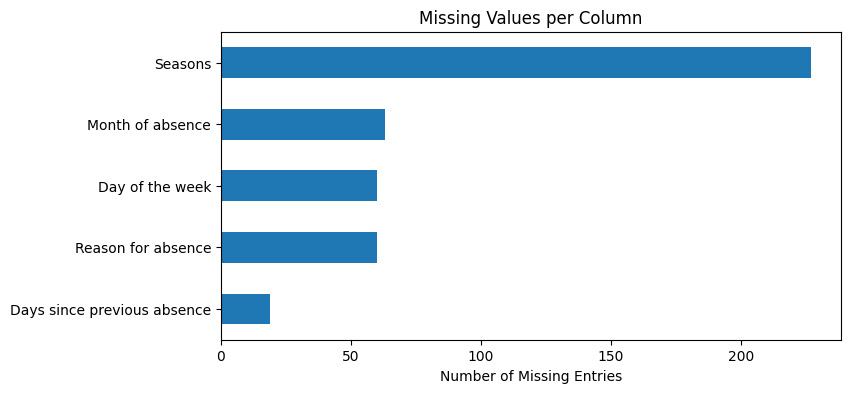

In [3]:
# Let's identify where we are missing values in our dataset
missing = df.isna().sum()
missing = missing[missing > 0]

plt.figure(figsize=(8,4))
missing.sort_values().plot(kind='barh')
plt.title("Missing Values per Column")
plt.xlabel("Number of Missing Entries")
plt.show()

# note: lots of missing data we need to pre-process properly

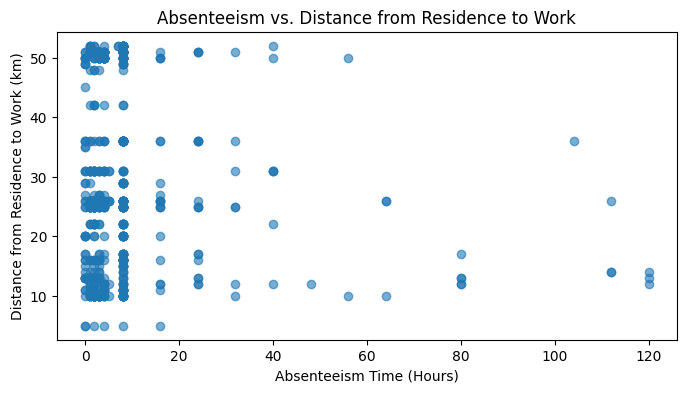

In [4]:
# Let's do a comparison between being absent and the distance they live from work.

plt.figure(figsize=(8,4))
plt.scatter(df['Absenteeism time in hours'], df['Distance from Residence to Work'], alpha=0.6)
plt.title("Absenteeism vs. Distance from Residence to Work")
plt.xlabel("Absenteeism Time (Hours)")
plt.ylabel("Distance from Residence to Work (km)")
plt.show()

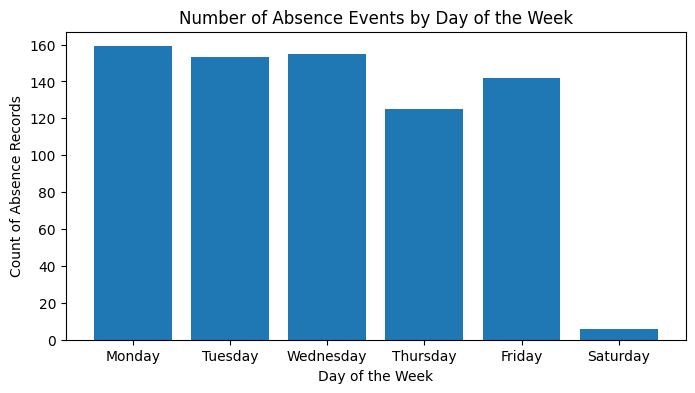

In [5]:
# Is there a correlation between the day of the week and absenteeism?
day_counts = df['Day of the week'].value_counts()

# I want the graph to visualize it in order from Monday - Sunday (not alphabetical)
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_counts = day_counts.reindex(weekday_order)

plt.figure(figsize=(8,4))
plt.bar(day_counts.index, day_counts.values)
plt.title("Number of Absence Events by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Count of Absence Records")
plt.show()


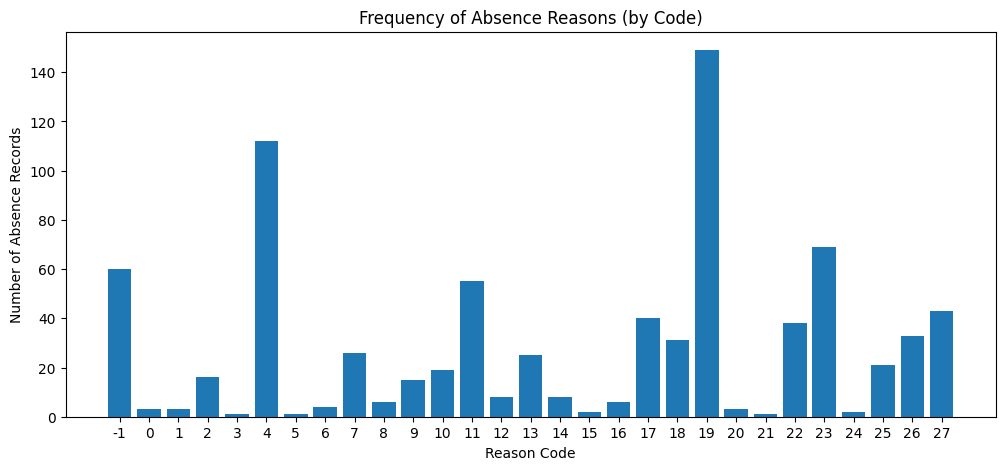

,Reason Code,Reason for absence
0,-1,NaN
1,0,Blood donation
2,1,Certain conditions originating in the perinata...
3,2,Certain infectious and parasitic diseases
4,3,"Congenital malformations, deformations and chr..."
5,4,Dental consultation
6,5,Diseases of the blood and blood-forming organs...
7,6,Diseases of the circulatory system
8,7,Diseases of the digestive system
9,8,Diseases of the ear and mastoid process
